In [7]:
import os, sys
# for accessing src, stan, etc.
sys.path.append(os.path.abspath(os.path.join("../..")))

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers.legacy import Adam # type: ignore
from tensorflow.keras.optimizers.schedules import CosineDecay # type: ignore

from bayesflow.trainers import Trainer
from bayesflow.amortizers import AmortizedPointEstimator
from bayesflow.helper_networks import ConfigurableMLP
from bayesflow.diagnostics import plot_recovery

from src.models.EyeMovements2 import model, configurator_posterior
#from amortizer_point_estimate import trainer

In [8]:
def build_summary_net(input_shape):
    # inputs (batch_size, sequence_length, (x, y, time))
    inputs = tf.keras.Input(shape=input_shape)


    # Extract temporal patterns and add them as skip connections
    conv_small = layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(inputs)
    #conv_med   = layers.Conv1D(filters=32, kernel_size=3, dilation_rate=10, padding='same', activation='relu')(inputs)
    conv_large = layers.Conv1D(filters=32, kernel_size=3, dilation_rate=50, padding='same', activation='relu')(inputs)
    x = layers.Concatenate()([inputs, conv_small, conv_large])
    
    # Bidirectional LSTM for temporal statistics
    # x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    
    # Self-attention mechanism
    attention = layers.MultiHeadAttention(num_heads=2, key_dim=32)
    a = attention(x, x, x)

    # Cross-attention mechanism
    lstm = layers.Bidirectional(layers.LSTM(32))(x)
    lstm = tf.expand_dims(lstm, axis=1)
    cross_attention = layers.MultiHeadAttention(num_heads=2, key_dim=32)
    outputs = cross_attention(lstm, a, a)
    outputs = outputs[:,0,:]

    # Fully connected layers
    # outputs = layers.GlobalAveragePooling1D()(x)#layers.Bidirectional(layers.LSTM(32))(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

summary_net = build_summary_net((None, 3))
amortizer = AmortizedPointEstimator(
    inference_net=ConfigurableMLP(input_dim=64, output_dim=4, dropout_rate=0.0),
    summary_net=summary_net,
    norm_ord=2
)

trainer = Trainer(amortizer=amortizer, generative_model=model, configurator=configurator_posterior, checkpoint_path="checkpoints/amortizer_point_estimate")

INFO:root:Loaded loss history from checkpoints/amortizer_point_estimate/history_10.pkl.
INFO:root:Networks loaded from checkpoints/amortizer_point_estimate/ckpt-10
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [ ]:
n_data_sets = 5_000
offline_data = trainer.generative_model(n_data_sets)

: 

In [ ]:
%time
epochs = 50
batch_size=64
iterations_per_epoch = int(n_data_sets/batch_size)
schedule = CosineDecay(0.005, epochs * iterations_per_epoch, name = "lr_decay")
optimizer = Adam(schedule, global_clipnorm = 1.0)
h=trainer.train_offline(simulations_dict=offline_data, epochs=epochs, batch_size=batch_size, validation_sims=100, optimizer=optimizer)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs


INFO:root:Generated 100 simulations for validation.
Training epoch 1: 100%|██████████| 79/79 [04:14<00:00,  3.22s/it, Epoch: 1, Batch: 79,Loss: 1.052,Avg.Loss: 1.692,LR: 4.99E-03]
INFO:root:Validation, Epoch: 1, Loss: 0.937
Training epoch 2: 100%|██████████| 79/79 [04:19<00:00,  3.28s/it, Epoch: 2, Batch: 79,Loss: 0.836,Avg.Loss: 0.937,LR: 4.98E-03]
INFO:root:Validation, Epoch: 2, Loss: 0.982
Training epoch 3: 100%|██████████| 79/79 [04:34<00:00,  3.48s/it, Epoch: 3, Batch: 79,Loss: 0.853,Avg.Loss: 0.890,LR: 4.95E-03]
INFO:root:Validation, Epoch: 3, Loss: 0.877
Training epoch 4: 100%|██████████| 79/79 [04:30<00:00,  3.42s/it, Epoch: 4, Batch: 79,Loss: 0.792,Avg.Loss: 0.884,LR: 4.92E-03]
INFO:root:Validation, Epoch: 4, Loss: 0.868
Training epoch 5: 100%|██████████| 79/79 [04:50<00:00,  3.67s/it, Epoch: 5, Batch: 79,Loss: 0.821,Avg.Loss: 0.886,LR: 4.87E-03]
INFO:root:Validation, Epoch: 5, Loss: 0.862
Training epoch 6: 100%|██████████| 79/79 [04:46<00:00,  3.62s/it, Epoch: 6, Batch: 79,Lo

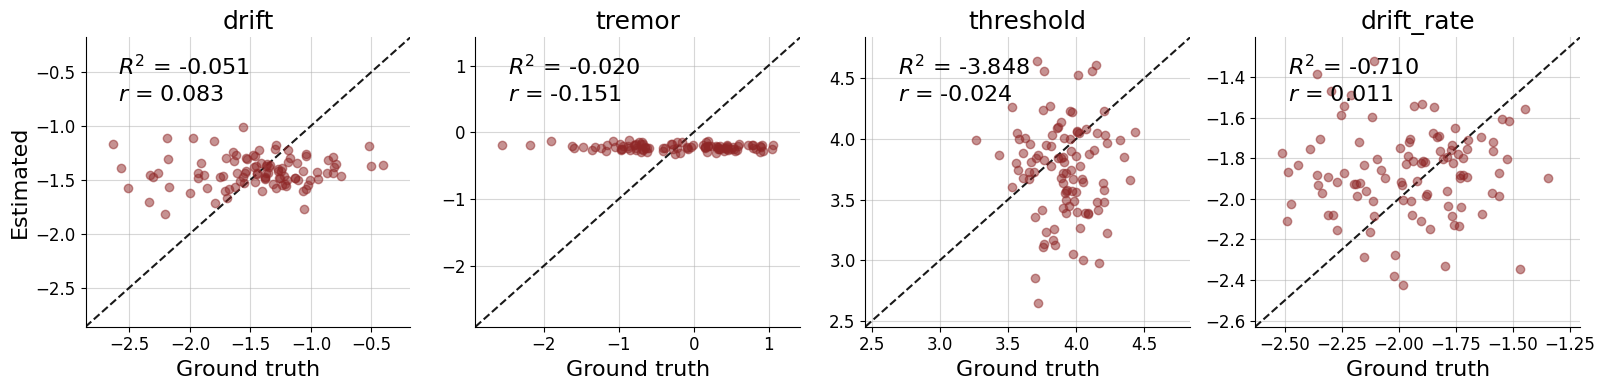

In [ ]:
df = configurator_posterior(model(100))
estimates = amortizer.estimate(df)
f = plot_recovery(
    estimates[:, None], df['parameters'], uncertainty_agg=lambda x, *args, **kwargs: tf.zeros_like(x)[:, 0],
    param_names=model.param_names[:4]
)